In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from model import *
from pickle_cache import PickleCache
import pandas as pd
from experiment_widgets import VariableArithmeticSequenceExperiment
import json
from random import sample, randint, choices
import string
import matplotlib.pyplot as plt 
import seaborn as sns
from enum import Enum
from itertools import permutations

sns.set()
pcache = PickleCache()

In [3]:
all_names = string.ascii_lowercase
all_operators = ['+', '-']

def generate_expression(variables):
    if len(variables) == 0:
        value = randint(1, 9)
        return str(value), value
    elif len(variables) == 1:
        rhs = randint(1, 9)
        op = choice(all_operators)
        expression = f"{variables[0]['variable']} {op} {rhs}"
        value = eval(f"{variables[0]['value']} {op} {rhs}")
        return expression, value
    else:
        [lhs, rhs] = sample(variables, k=2)
        op = choice(all_operators)
        expression = f"{lhs['variable']} {op} {rhs['variable']}"
        value = eval(f"{lhs['value']} {op} {rhs['value']}")
        return expression, value

def generate_trial():
    K = 10
    names = sample(all_names, k=K)
    variables = []
    for i in range(K):
        expression, value = generate_expression(variables)
        variables.append({
            'variable': names[i],
            'expression': expression,
            'value': value
        })
    
    return {
        'variables': variables, 
        'wait_time': 1000
    }

def exp_name(N_trials):
    return f'vararithseq_{N_trials}'

In [4]:
N_trials = 10

experiment = {
    'trials': [generate_trial() for _ in range(N_trials)],
    'between_trials_time': 1000
}

exp = VariableArithmeticSequenceExperiment(experiment=json.dumps(experiment), results='[]')

def on_result_change(_):
    pcache.set(exp_name(N_trials), {
        'experiment': experiment,
        'results': json.loads(exp.results)
    })
    
#exp.observe(on_result_change)

exp

VariableArithmeticSequenceExperiment(experiment='{"trials": [{"variables": [{"variable": "k", "expression": "2…

Text(0.5, 1.0, 'Distribution of errors across stages')

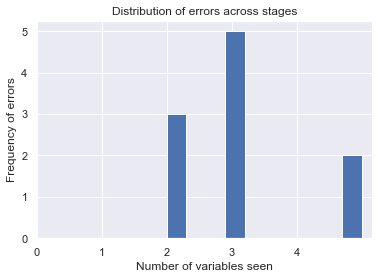

In [5]:
data = pcache.get(exp_name(N_trials))
experiment = data['experiment']
results = [r['response'] for r in data['results']]


ax = pd.Series([r['i'] for r in results]).plot.hist()
ax.set_xticks(list(range(0, 5)))
ax.set_xlabel('Number of variables seen')
ax.set_ylabel('Frequency of errors')
ax.set_title('Distribution of errors across stages')

In [6]:
class ErrorType(Enum):
    Substitution = 1
    Calculation = 2
    
def analyze_error(variables, expression, guess):
    possible_values = [v['value'] for v in variables]
    ast = parse(expression).statements[0].value
    if len(variables) == 0:
        return ErrorType.Calculation
    
    op = ast.operator
    for (a, b) in permutations(possible_values, 2):
        if op.eval(a, b) == guess:
            return ErrorType.Substitution
    return ErrorType.Calculation
    
def process_results(experiment, results):
    df = []    
    for (trial, result) in zip(experiment['trials'], results):
        variables = trial['variables']
        i = result['i']
        error = analyze_error(variables[:i], variables[i]['expression'], result['value'])
        df.append({
            'stage': i,
            'error': error 
        })
    return pd.DataFrame(df)


In [7]:
df = process_results(experiment, results)

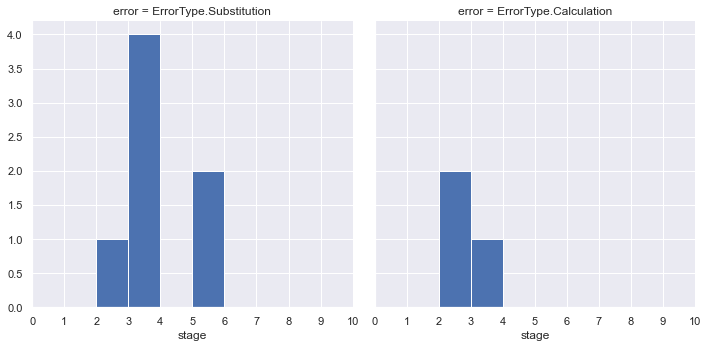

In [8]:
def plot_errors(df):
    bins = list(range(11))
    g = sns.FacetGrid(data=df, col='error', height=5, xlim=(bins[0], bins[-1]), 
                      col_order=[ErrorType.Substitution, ErrorType.Calculation])
    g.map(plt.hist, 'stage', bins=bins)
    g.set(xticks=bins)
    g.set_xticklabels(bins)
    
plot_errors(df)    

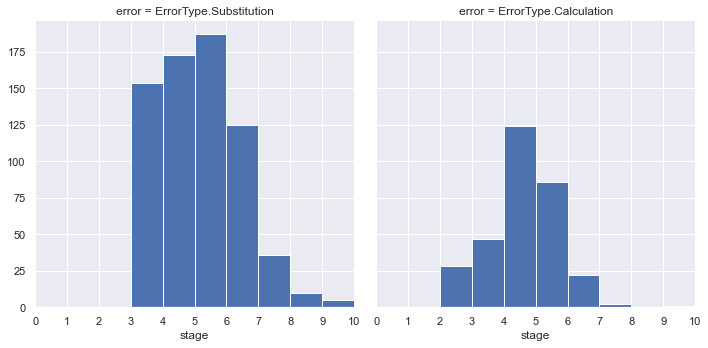

In [15]:
def model(trial):
    wm = WorkingMemory()
    
    for i, var in enumerate(trial['variables']):
        name = var['variable']
        stmt = parse(f"{name} = {var['expression']}").statements[0]
        trace_stmt(stmt, wm)        
        response = wm.fetch_var(name)
        response = response if response is not None else guess()
        if response != var['value']:
            return {
                'i': i,
                'value': response
            }
    
    return {'i': i, 'value': 0}
        
#data = pcache.get(exp_name(N_trials))
#trials = data['experiment']['trials']
trials = [generate_trial() for _ in range(1000)]
results = [model(trial) for trial in trials]
df_sim = process_results({'trials': trials}, results)
plot_errors(df_sim)